# My First Neural Network

**AIM:** To predict daily bike rental ridership 

**Key Concepts:** Backpropagation, gradient descent, simple neural network


In [1]:
%matplotlib inline
# %load_ext autoreload  
# #autoreload reloads modules automatically before entering the execution of code
# %autoreload 2   
# #Reload all modules every time before executing the Python code typed
%config InlineBackend.figure_format = 'retina'   #png makes the notebook bulky

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare data

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
rides.describe(include = ['O'])

,dteday
count,17379
unique,731
top,2011-06-21
freq,24


In [4]:
print ('Seasons:', rides['season'].unique())
print ('Holidays:', rides['holiday'].unique())
print ('Year:', rides['yr'].unique())
print ('Months:', rides['mnth'].unique())
print ('Working Day:', rides['workingday'].unique())
print ('Weekdays:', rides['weekday'].unique())
print ('Weather Situation:', rides['weathersit'].unique())

Seasons: [1 2 3 4]
Holidays: [0 1]
Year: [0 1]
Months: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Working Day: [0 1]
Weekdays: [6 0 1 2 3 4 5]
Weather Situation: [1 2 3 4]


In [5]:
#Just to see if any null values in data
rides.isnull().values.any()

False

## Understanding data

- Data has the riders for each hour from **1/1/2011 to 31/12/2012**.
- **Seasons**: 
    - 1: springer 
    - 2: summer 
    - 3: fall 
    - 4: winter
- **Year**: 
    - 0: 2011 
    - 1: 2012
- **Weather Situation** :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

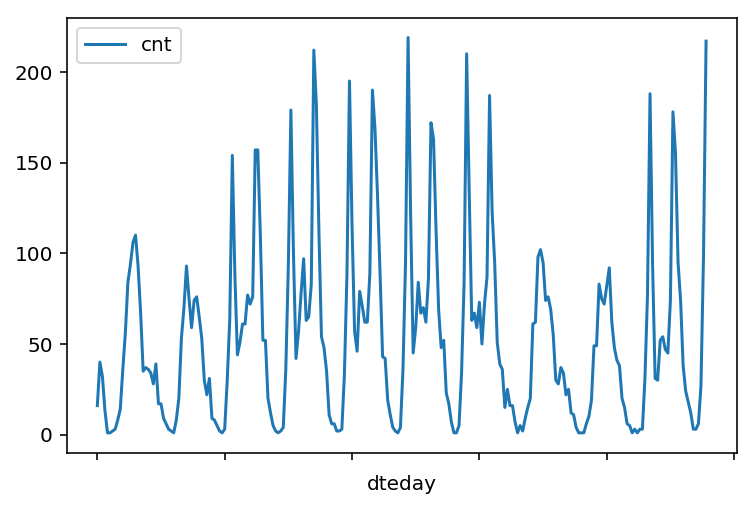

In [6]:
rides[:24*10].plot(x='dteday', y='cnt')

## Data conversion
1. Creating **Dummy Variables** for categorial values
2. Standardizing continuous variables to **mean = 0** and **standard deviation = 1**

In [7]:
dummy_fields = ['season','mnth','hr','weekday','weathersit']

# Adding the dummy variables for each categorial value
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)
    
# Dropping unwanted columns
drop_these = ['instant', 'dteday', 'season', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit', 'atemp']
data = rides.drop(drop_these, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,1,1,0,0,0
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,1,1,0,0,0
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,1,1,0,0,0
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,1,1,0,0,0


In [8]:
# Now, scaling target variables
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [9]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0,0,0,0,0,1,1,0,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0,0,0,0,0,1,1,0,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0,0,0,0,0,1,1,0,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0,0,0,0,0,1,1,0,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0,0,0,0,0,1,1,0,0,0


## Splitting the data into training, testing and validation sets
We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [10]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

In [11]:
# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']

features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [12]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Build the Network!

In [13]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        # Activation function is the sigmoid function
        self.activation_function = lambda x : (1/(1+np.exp(-x)))
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        ### Forward pass ###
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        ### Backward pass ###
        # Output error
        output_errors = targets - final_outputs
        
        # Backpropagated error
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)
        hidden_grad = (hidden_outputs)*(1-hidden_outputs)
        
        # Update the weights
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T)
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors * hidden_grad, inputs.T)
 
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Forward pass ####
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        return final_outputs

In [14]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [15]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0,0,0,0,0,1,1,0,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0,0,0,0,0,1,1,0,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0,0,0,0,0,1,1,0,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0,0,0,0,0,1,1,0,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0,0,0,0,0,1,1,0,0,0


## Train the network

In [ ]:
import sys

### Set the hyperparameters here ###
epochs = 10000
learning_rate = 0.003
hidden_nodes = 19
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

/anaconda2/envs/firstproject/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
/anaconda2/envs/firstproject/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Progress: 74.0% ... Training loss: 0.056 ... Validation loss: 0.147

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim()

/anaconda2/envs/firstproject/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


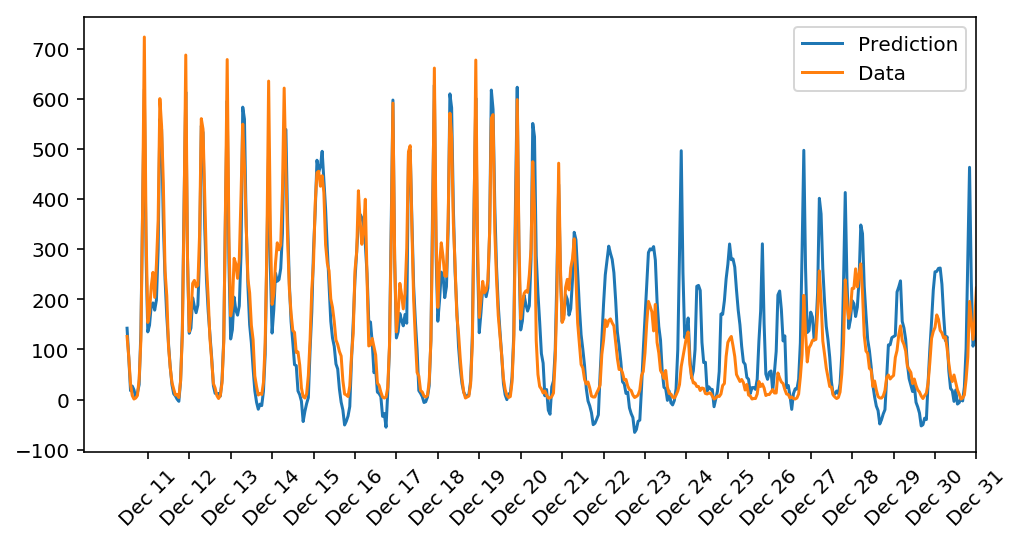

In [77]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Unit tests

In [78]:
import unittest

inputs = [0.5, -0.2, 0.1]
targets = [0.4]
test_w_i_h = np.array([[0.1, 0.4, -0.3], 
                       [-0.2, 0.5, 0.2]])
test_w_h_o = np.array([[0.3, -0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328, -0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014,  0.39775194, -0.29887597],
                                              [-0.20185996,  0.50074398,  0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Remarks

Here, from our predictions graph we observe that model doesn't predict well around the christmas i.e. 24th Dec to 27th Dec. This is majorly due to the absence of the data during that period.